In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
counts = np.loadtxt('data/txtdata.csv')

<BarContainer object of 74 artists>

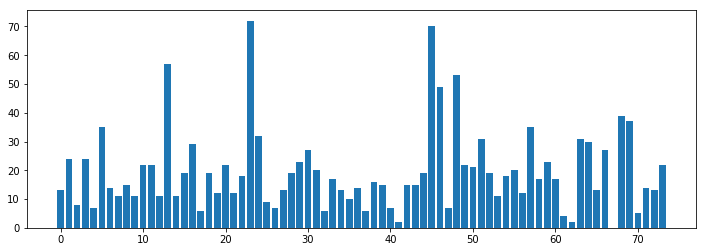

In [3]:
ncounts = len(counts)
plt.figure(figsize=(12,4))
plt.bar(np.arange(ncounts), counts)

Need to guess how many changepoints there will be

Say we think there are between 1 and 5, all equally likely

In [4]:
changes = pm.DiscreteUniform('changes', 1, 5)

In [5]:
changes.value

array(4)

In [6]:
@pm.deterministic
def size(N=changes):
    return N

In [7]:
int(size)

4

Now we need to figure out on what days each of these changes occurred

In [8]:
taus = []

@pm.deterministic
def tau0(lower=0, upper=ncounts-5):
    return pm.DiscreteUniform('tau0', lower=0, upper=ncounts-5)

taus.append(tau0)
last_tau = tau0

for i in range(1, int(size)):
    @pm.deterministic
    def taunew(lower=last_tau, upper=ncounts-5):
        return pm.DiscreteUniform('tau{}'.format(i), lower=last_tau, upper=ncounts-5)
    
    taunew.__name__ = 'tau{}'.format(i)
    last_tau = taunew
    
    taus.append(taunew)

In [9]:
len(taus)

4

In [10]:
taus

[<pymc.PyMCObjects.Deterministic 'tau0' at 0x7f7ba6068090>,
 <pymc.PyMCObjects.Deterministic 'tau1' at 0x7f7ba628da10>,
 <pymc.PyMCObjects.Deterministic 'tau2' at 0x7f7ba61da8d0>,
 <pymc.PyMCObjects.Deterministic 'tau3' at 0x7f7ba61dac90>]

And there have to be n+1 as many lambdas

In [11]:
alpha = 1.0/counts.mean()
alpha

0.05065023956194388

In [12]:
lambdas = []

for i in range(int(size)+1):
    lambdas.append(pm.Exponential('lambda{}'.format(i), alpha))

In [13]:
len(lambdas)

5

In [14]:
lambdas

[<pymc.distributions.Exponential 'lambda0' at 0x7f7ba625d590>,
 <pymc.distributions.Exponential 'lambda1' at 0x7f7ba625dd50>,
 <pymc.distributions.Exponential 'lambda2' at 0x7f7ba626b750>,
 <pymc.distributions.Exponential 'lambda3' at 0x7f7ba626be50>,
 <pymc.distributions.Exponential 'lambda4' at 0x7f7ba626b3d0>]

In [15]:
@pm.deterministic
def lambdas_(taus=taus, lambdas=lambdas):
    out = np.empty(ncounts)
    
    start = 0
    for i in range(len(taus)):
        out[start:int(taus[i])] = lambdas[i]
        start = int(taus[i])
    out[int(taus[len(taus)-1]):] = lambdas[len(taus)]
    
    return out

In [16]:
obs = pm.Poisson('obs', lambdas_, value=counts, observed=True)

In [17]:
model = pm.Model([obs, pm.Container(lambdas), pm.Container(taus), changes])

In [18]:
mcmc = pm.MCMC(model)

In [19]:
mcmc.sample(100000, 25000)

 [-----------------100%-----------------] 100000 of 100000 complete in 39.1 sec

In [20]:
changesamp = mcmc.trace('changes')[:]

(array([0.49626667, 0.        , 0.5004    , 0.        , 0.        ,
        0.49456667, 0.        , 0.50326667, 0.        , 0.5055    ]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

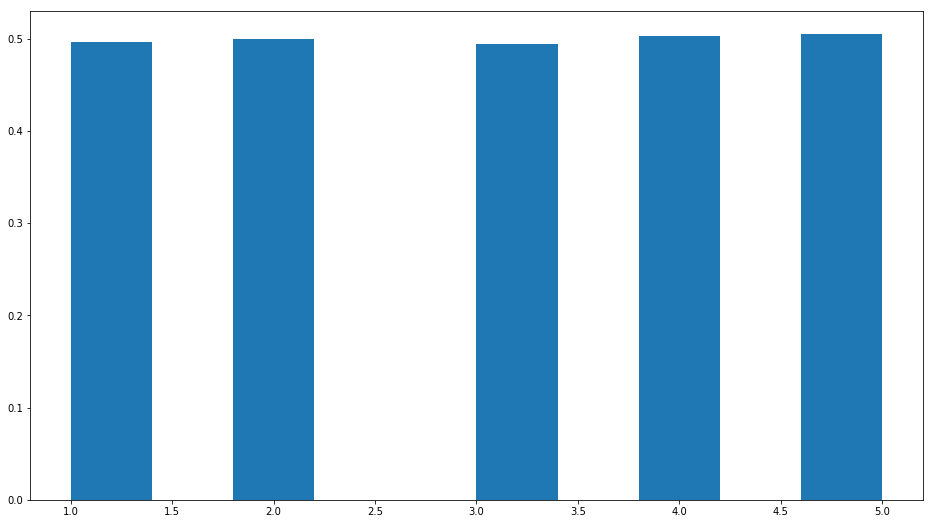

In [21]:
plt.figure(figsize=(16,9))
# w = 1.0 / changesamp.shape[0] * np.ones_like(changesamp)
plt.hist(changesamp, density=True)
# plt.xlim([34, 54])
# plt.axvline(changesamp.mean(), color='red')

In [22]:
changesamp.mean()

3.0085333333333333

In [23]:
changesamp.std()

1.4157049535674993